In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 22s 260ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910 - val_loss: 0.1745 - val_root_mean_squared_error: 0.4178
Epoch 2/50
53/53 [==============================] - 13s 243ms/step - loss: 0.1554 - root_mean_squared_error: 0.3942 - val_loss: 0.0821 - val_root_mean_squared_error: 0.2865
Epoch 3/50
53/53 [==============================] - 11s 209ms/step - loss: 0.0852 - root_mean_squared_error: 0.2919 - val_loss: 0.0768 - val_root_mean_squared_error: 0.2771
Epoch 4/50
53/53 [==============================] - 12s 232ms/step - loss: 0.0785 - root_mean_squared_error: 0.2802 - val_loss: 0.0732 - val_root_mean_squared_error: 0.2705
Epoch 5/50
53/53 [==============================] - 13s 247ms/step - loss: 0.0709 - root_mean_squared_error: 0.2663 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571
Epoch 6/50
53/53 [==============================] - 14s 267ms/step - loss: 0.0657 - root_mean_squared_error: 0.2564 - val_loss: 0.0577 

Epoch 29/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 30/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 31/50
53/53 [==============================] - 12s 233ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 32/50
53/53 [==============================] - 11s 211ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 33/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 34/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0034 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.933265841007232 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

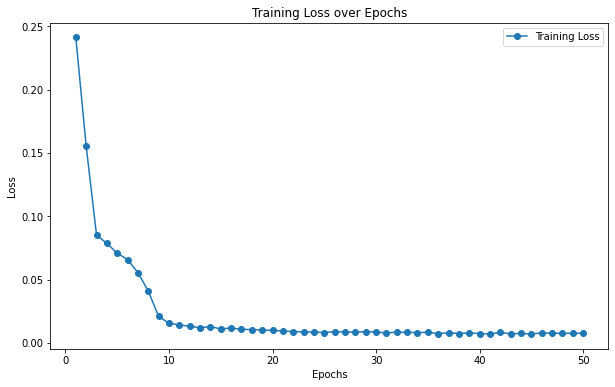

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

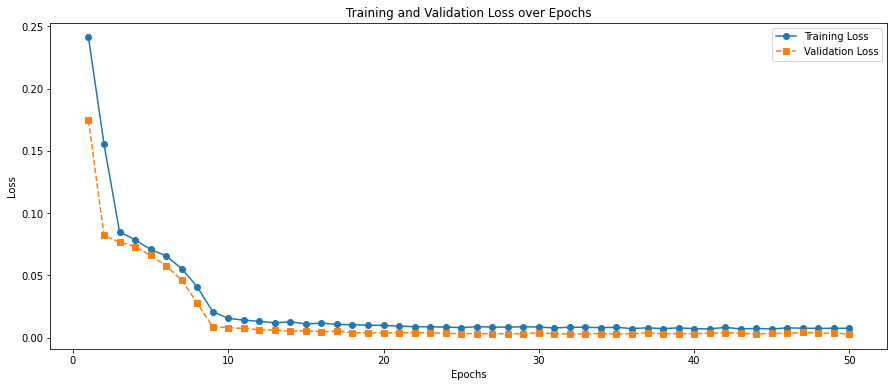

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 20ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06183524235382766
MAE : 0.04921058682573911


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.396872e+05,291275.949
1,8.952089e+05,678576.504
2,1.121119e+06,974461.347
3,1.223347e+06,1181121.087
4,1.231986e+06,1236299.254
5,1.117251e+06,1036981.003
6,8.621696e+05,847489.150
7,5.748746e+05,619129.338
8,3.059496e+05,195688.491
9,1.188595e+05,36670.811


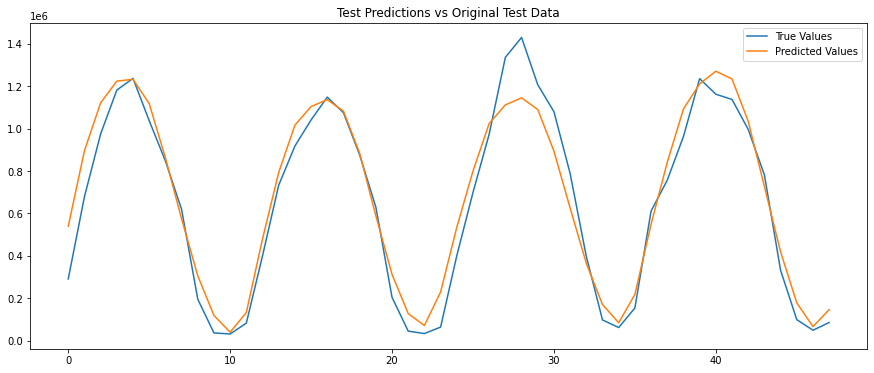

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

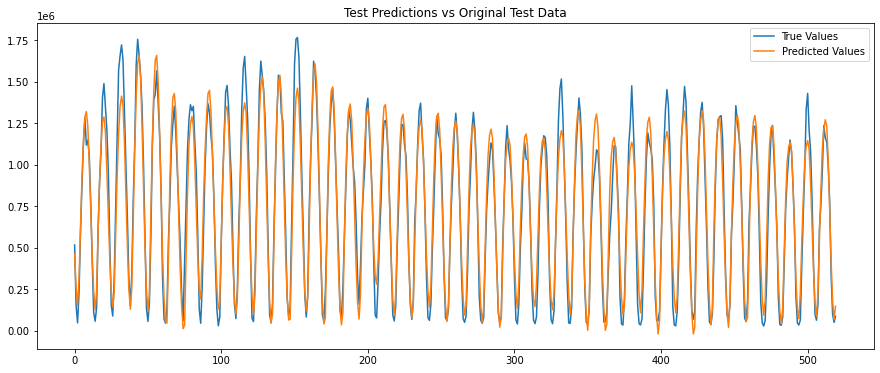

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()